## 准备好建立网络所需

In [83]:
import numpy as np

In [84]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

def dfunc(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:     
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def cross_entropy_err(y_hat, y):
    delta = 1e-8
    return -np.sum(y*np.log(y_hat + delta))

In [85]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid_function(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax_function(a2)
        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return cross_entropy_err(y_hat, y)
        
    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        grads = {}
        grads['W1'] = dfunc(loss_W, self.params['W1'])
        grads['b1'] = dfunc(loss_W, self.params['b1'])
        grads['W2'] = dfunc(loss_W, self.params['W2'])
        grads['b2'] = dfunc(loss_W, self.params['b2'])
        return grads

## 建立一两层神经网络

In [86]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

In [88]:
net.params['W1'].shape
net.params['b1'].shape

(5,)

In [90]:
net.params['W2'].shape
net.params['b2'].shape

(3,)

## 准备好建立网络所需数据

In [91]:
from sklearn.datasets import load_iris
iris = load_iris()
x= iris.data

In [93]:
#x

In [94]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [95]:
y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
    y[idx, val] = 1

In [97]:
#y

In [98]:
y_hat = net.predict(x)

In [100]:
#y_hat

## 训练类神经网络

In [101]:
epochs = 3000
lr     = 0.01

train_loss = []
for i in range(epochs):         
    grad = net.numerical_gradient(x,y)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x, y)
    train_loss.append(loss)

In [103]:
#train_loss

## 训练损失图

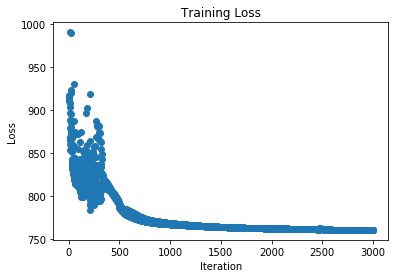

In [104]:
import matplotlib.pyplot as plt
plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 验证模型准确度

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix
#net.predict(x)
predicted = np.argmax(net.predict(x), axis=1)

In [108]:
#predicted

In [109]:
# accuracy
sum(predicted == iris.target) / len(iris.target)

0.98

In [110]:
# accuracy
accuracy_score(iris.target, predicted)

0.98

In [111]:
# confusion matrix
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  0, 50]])

## 调整交叉熵 

In [112]:
def cross_entropy_err(y_hat, y):
    y      = y.reshape(1, y.size)
    y_hat  = y_hat.reshape(1, y_hat.size)
    batch_size = y_hat.shape[0]
    return -np.sum(y * np.log(y_hat)) / batch_size

## 批次学习

In [113]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

epochs     = 3000
lr         = 0.01
batch_size = 30

train_loss = []
for i in range(epochs): 
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch   = iris.data[idx]
    y_batch   = y[idx]
    grad = net.numerical_gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)

Text(0.5,1,'Training Loss')

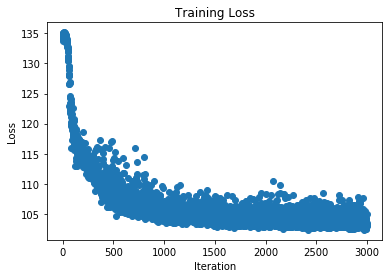

In [114]:
plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix
predicted = np.argmax(net.predict(x), axis=1)

# accuracy
sum(predicted == iris.target) / len(iris.target)

0.9733333333333334

In [116]:
# accuracy
accuracy_score(iris.target, predicted)

0.9733333333333334

In [117]:
# confusion matrix
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]])